# Record Store Scenario - answering business questions with SQL

### Intro

The dataset is based on a fictional record store called Chinook, and contains several different tables with information regarding record sales and related data including customer, employee, sales, track info etc.

The schema provided below shows the contents of the different tables, and their relational columns used for joining. 

### Business questions

### Question 1

The Chinook record store has just signed a deal with a new record label, and you've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:


- Regal: 	Hip-Hop
- Red Tone: 	Punk
- Meteor and the Girls: 	Pop
- Slim Jim Bites: 	Blues

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

You'll need to write a query to find out which genres sell the most tracks in the USA, write up a summary of your findings, and make a recommendation for the three artists whose albums we should purchase for the store.

### Question 2
Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. You have been asked to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

### Question 3

Analyze the sales data for customers from each different country.

Write a query that collates data on purchases from different countries, by:

    Where a country has only one customer, collect them into an "Other" group.
    The results should be sorted by the total sales from highest to lowest, with the "Other" group at the very bottom.
    For each country, include:
        total number of customers
        total value of sales
        average value of sales per customer
        average order value

### Question 4

Currently, the Chinook store is set up to allow customers to make purchases in one of two ways:
1. purchase a whole album
2. purchase a collection of one or more individual tracks


The store does not currently support letting customers purchase a whole album and then add individual tracks to it. When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

The task is to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

In [1]:
#to visualise the tables
import pandas as pd
import numpy as np
import sqlite3
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Defining a function for creating grouped bar charts
def plot_grouped_bar_chart(fig_width, fig_height, 
                           column1, column2, 
                           label1, label2, 
                           title, ylabel, 
                           ylim_lower, ylim_upper, 
                           loc, rotation, bbox_to_anchor):
    
    # Converting series to lists
    column1_list = column1.to_list()   
    column2_list = column2.to_list()
        
    # Creating labels from the index
    labels = df.index.to_list()
    
    # Specifying the label locations and the width of the bars
    x = np.arange(len(labels)) 
    width = 0.35
    
    # Plotting the data
    fig, ax = plt.subplots(figsize=(10,6))
    ax.bar(x - width/2,
           column1_list,
           width, 
           label=label1)
    ax.bar(x + width/2,
           column2_list, 
           width,
           label=label2)
    ax.set_title(title, fontsize=30)
    ax.set_ylabel(ylabel, fontsize=20)
    ax.set_ylim(ylim_lower, ylim_upper)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, 
                       fontsize=17, 
                       rotation=rotation)
    ax.tick_params(bottom = False, 
                   labelsize=17)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.legend(loc=loc, 
              bbox_to_anchor=bbox_to_anchor,
              fontsize=16, 
              frameon=False)

In [3]:
#import schema image, provided with SQL scenario
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://s3.amazonaws.com/dq-content/191/chinook-schema.svg")

In [4]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

'Connected: None@chinook.db'

# Exploratory steps - getting familiar with the data

In [5]:
%%sql
SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ("table","view");

Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


# Business question 1 - selecting albums to purchase


In [6]:
query = """
WITH

usa AS (SELECT invoice_line.* FROM invoice_line
        INNER JOIN invoice ON invoice_line.invoice_id = invoice.invoice_id
        INNER JOIN customer ON invoice.customer_id = customer.customer_id
             WHERE customer.country = "USA")



SELECT genre.name AS genre, COUNT(usa.invoice_line_id) AS total_tracks_sold, ROUND(CAST(COUNT(usa.invoice_line_id) AS FLOAT) / (SELECT COUNT(*) FROM usa) * 100, 2) AS pct_sold
  FROM usa
INNER JOIN track ON track.track_id = usa.track_id
INNER JOIN genre ON genre.genre_id = track.genre_id
GROUP BY 1
ORDER BY 2 DESC
"""
# Reading SQL results into a pandas DataFrame
conn = sqlite3.connect("chinook.db")
df = pd.read_sql_query(query, conn) 
df


,genre,total_tracks_sold,pct_sold
0,Rock,561,53.38
1,Alternative & Punk,130,12.37
2,Metal,124,11.80
3,R&B/Soul,53,5.04
4,Blues,36,3.43
5,Alternative,35,3.33
6,Latin,22,2.09
7,Pop,22,2.09
8,Hip Hop/Rap,20,1.90
9,Jazz,14,1.33


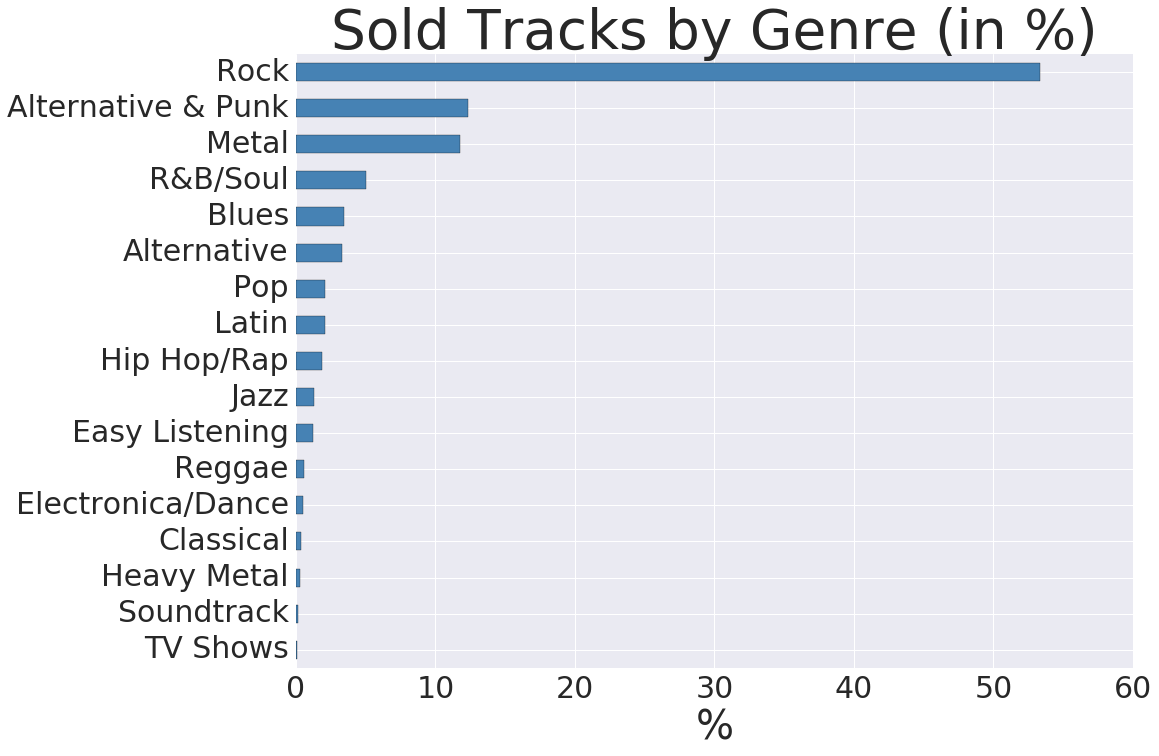

In [7]:
# Resetting the index
df = df.set_index(df["genre"], drop=True) 

# Plotting sold tracks by genre in %
fig, ax = plt.subplots(figsize=(15,11))
df["pct_sold"].sort_values().plot.barh(color="steelblue",
                                  xlim=(0, 60),
                                  rot=0)
ax.set_title("Sold Tracks by Genre (in %)", fontsize=55)
ax.set_ylabel(None).set_visible(False)
ax.set_xlabel("%", fontsize=40)
ax.tick_params(axis="both", 
               labelsize=30, 
               left = False, right = False, top = False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
plt.show()

### Observations

Music from the Rock genre accounts for over half (53.38 %) of all tracks sold in USA. The second is alternative and punk at 12.37%.

Based on the business question, Rock music sells the best in the USA, followed by Punk. The three artists that should be focused on are:

- 'Red Tone' that play Punk music (12.37%)
- 'Slim Jim Bites' that play Blues music (3.43%)
- 'Meteor and the Girls' that play Pop music (2.09%(

# Business question 2 - performance of sales employees

**Approach**

1. subquery to SELECT data to identify each customer (customer_id) and total sales, grouped by each customer and corresponding support rep
2. SELECT sales reps' name using concatenation; and other relevants columns from employee table to help interpretation

In [8]:
%%sql

SELECT (em.first_name || " " || em.last_name) AS agent_name, em.country AS location, em.title, em.hire_date
FROM employee as em

Done.


agent_name,location,title,hire_date
Andrew Adams,Canada,General Manager,2016-08-14 00:00:00
Nancy Edwards,Canada,Sales Manager,2016-05-01 00:00:00
Jane Peacock,Canada,Sales Support Agent,2017-04-01 00:00:00
Margaret Park,Canada,Sales Support Agent,2017-05-03 00:00:00
Steve Johnson,Canada,Sales Support Agent,2017-10-17 00:00:00
Michael Mitchell,Canada,IT Manager,2016-10-17 00:00:00
Robert King,Canada,IT Staff,2017-01-02 00:00:00
Laura Callahan,Canada,IT Staff,2017-03-04 00:00:00


In [9]:


query = """ 
WITH

agents AS (SELECT invoice.customer_id, customer.support_rep_id, SUM(invoice.total) as sales
             FROM invoice
           INNER JOIN customer on invoice.customer_id = customer.customer_id
           GROUP BY 2)

SELECT (em.first_name || " " || em.last_name) AS agent_name, em.country AS location, em.title, em.hire_date, ROUND(agents.sales, 2) AS total
FROM agents
INNER JOIN employee AS em ON em.employee_id = agents.support_rep_id
GROUP BY 1;
""" 
conn = sqlite3.connect("chinook.db")
df_2 = pd.read_sql_query(query, conn).set_index("agent_name", drop=True) 


df_2

,location,title,hire_date,total
agent_name,,,,
Jane Peacock,Canada,Sales Support Agent,2017-04-01 00:00:00,1731.51
Margaret Park,Canada,Sales Support Agent,2017-05-03 00:00:00,1584.00
Steve Johnson,Canada,Sales Support Agent,2017-10-17 00:00:00,1393.92


/dataquest/system/env/python3/lib/python3.4/site-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



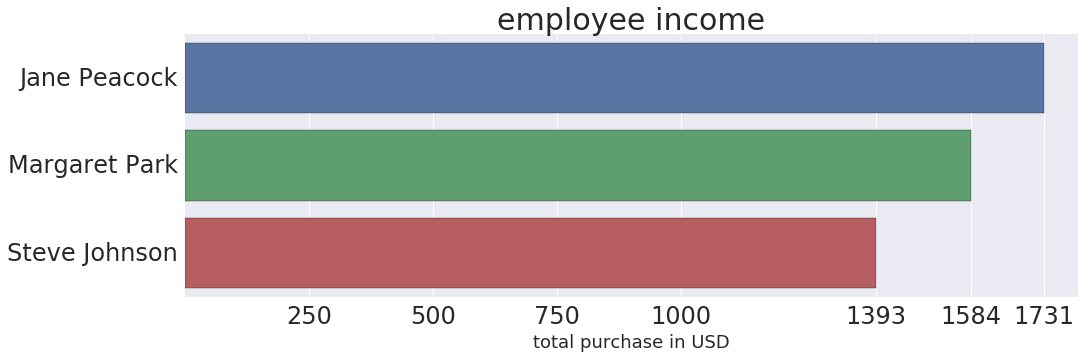

In [10]:
df_2 = df_2.reset_index()

plt.figure(figsize=(16, 16))
plt.subplot(3, 1, 1)
sns.barplot(x='total', y='agent_name', data=df_2)
plt.xticks([250, 500, 750, 1000, 1393, 1584, 1731])
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel("total purchase in USD", fontsize=18)
plt.ylabel("", fontsize=18)
plt.title('employee income', fontsize=30)

### Observations

Jane is the top sales agent, however she has been at the company longer based on her hire date. The differences in sales could be accounted for based on their length of service. 

# Business question 3 - country sales data

**Approach**

1. subquery to SELECT relevant customer and country information from the customer table
2. second subquery to SELECT sales information from invoice table
3. SELECT final columns to display, using arithmetic operators to calculate total/averages
4. INNER JOIN the two subqueries together
5. then final grouping/ordering by country and customers

In [11]:
%%sql

WITH

country AS (SELECT customer_id, country, first_name, last_name FROM customer
            GROUP BY customer_id),

total_sales AS (SELECT customer_id, total, invoice.invoice_id, invoice_line.unit_price FROM invoice
                INNER JOIN invoice_line ON invoice_line.invoice_id = invoice.invoice_id
                )
SELECT country.country AS country, COUNT(DISTINCT country.customer_id) as total_customers,
ROUND(SUM(total_sales.unit_price), 2) AS total_sales,
ROUND(SUM(total_sales.unit_price) / COUNT(DISTINCT total_sales.invoice_id), 2) AS avg_order_val,
ROUND(SUM(total_sales.unit_price) / COUNT(DISTINCT total_sales.customer_id), 2) AS avg_val_sale_per_cust
FROM country
INNER JOIN total_sales ON total_sales.customer_id = country.customer_id
GROUP BY 1
ORDER BY 2 DESC

Done.


country,total_customers,total_sales,avg_order_val,avg_val_sale_per_cust
USA,13,1040.49,7.94,80.04
Canada,8,535.59,7.05,66.95
Brazil,5,427.68,7.01,85.54
France,5,389.07,7.78,77.81
Germany,4,334.62,8.16,83.66
United Kingdom,3,245.52,8.77,81.84
Czech Republic,2,273.24,9.11,136.62
India,2,183.15,8.72,91.58
Portugal,2,185.13,6.38,92.57
Argentina,1,39.6,7.92,39.6


**Approach - grouping countries with only 1 customer as "Other"**

Same as above, but adding a sorting column with a CASE statement for the country column, then sorting by it.

Originally tried using:

``` 
SELECT
                         CASE
                             WHEN (
                                 SELECT COUNT(*) 
                                 FROM customer
                                 WHERE country = customer.country
                                ) = 1 THEN "Other"
                        ELSE customer.country
```
However, nothing was changing. Since I've used customer already in this subquery for the FROM clause, I think SQL was getting confused so had to explicitly state to use the other customer table (aliased as c) defined outside this subquery here:

```
c.customer_id, invoice_line.* 
                    FROM invoice_line
                    INNER JOIN invoice ON invoice.invoice_id = invoice_line.invoice_id
                    INNER JOIN customer AS c ON c.customer_id = invoice.customer_id
                     )
```

**Final CASE statement**

```
WITH country_other AS 
                  (
                   SELECT
                         CASE
                             WHEN (
                                 SELECT COUNT(*) 
                                 FROM customer
                                 WHERE country = c.country
                                ) = 1 THEN "Other"
                        ELSE c.country
                    END AS country, 
                    c.customer_id, invoice_line.* 
                    FROM invoice_line
                    INNER JOIN invoice ON invoice.invoice_id = invoice_line.invoice_id
                    INNER JOIN customer AS c ON c.customer_id = invoice.customer_id
                     )
```

**Explanation**

This did take some time to get my head around, so i'm writing an explanation for my own future reference and to explain the logic I used to come about this answer!

1. ```WHERE``` clause to filter each row in country
2. ```SELECT COUNT(*)``` to count the number of rows after the WHERE clause runs, so for each row corresponding to each distinct country, it will be counted. e.g. 13 rows with country = USA, so count will be 13. if only 1 row, count will be 1.
3. when the above ```SELECT COUNT(*)``` runs and returns a value of 1, ```THEN "Other"``` condition is fulfilled and is assigned "Other"
4. the ```ELSE c.country``` means if the COUNT is > 1, the name of the actual country is returned

So, to summarise: when the COUNT = 1, it is labelled "Others", if the COUNT > 1, it is labelled by it's country name.

on the WHERE clause, ```WHERE country = c.country```, the country on the left hand side is part of the inner query, whereas the (aliased) country on the right hand side is part of the outer query. 

In [12]:
query = """
WITH country_other AS 
                  (
                   SELECT
                         CASE
                             WHEN (
                                 SELECT COUNT(*) 
                                 FROM customer
                                 WHERE country = c.country
                                ) = 1 THEN "Other"
                        ELSE c.country
                    END AS country, 
                    c.customer_id, invoice_line.* 
                    FROM invoice_line
                    INNER JOIN invoice ON invoice.invoice_id = invoice_line.invoice_id
                    INNER JOIN customer AS c ON c.customer_id = invoice.customer_id
                     )

SELECT country, total_customers, total_sales, avg_order_val, avg_val_sale_per_cust
FROM
(SELECT 
country, COUNT(DISTINCT customer_id) as total_customers,
ROUND(SUM(unit_price), 2) AS total_sales,
ROUND(SUM(unit_price) / COUNT(DISTINCT invoice_id), 2) AS avg_order_val,
ROUND(SUM(unit_price) / COUNT(DISTINCT customer_id), 2) AS avg_val_sale_per_cust,
      CASE
          WHEN country = "Other" THEN 1
          ELSE 0
        END AS sort
FROM country_other
GROUP BY 1
ORDER BY sort ASC, total_sales DESC);
"""

# Reading SQL results into a pandas DataFrame
conn = sqlite3.connect("chinook.db")
df = pd.read_sql_query(query, conn).set_index("country", drop=True)

df

,total_customers,total_sales,avg_order_val,avg_val_sale_per_cust
country,,,,
USA,13,1040.49,7.94,80.04
Canada,8,535.59,7.05,66.95
Brazil,5,427.68,7.01,85.54
France,5,389.07,7.78,77.81
Germany,4,334.62,8.16,83.66
Czech Republic,2,273.24,9.11,136.62
United Kingdom,3,245.52,8.77,81.84
Portugal,2,185.13,6.38,92.57
India,2,183.15,8.72,91.58


/dataquest/system/env/python3/lib/python3.4/site-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



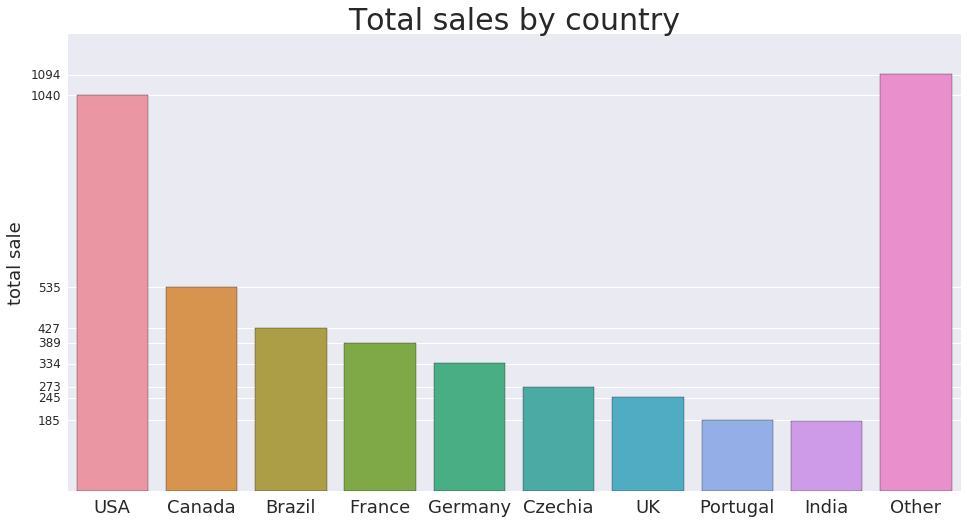

In [13]:
# SQL result to pandas df:
conn = sqlite3.connect("chinook.db")
df_3 = pd.read_sql_query(query, conn).reset_index() #first index i.e. country



# renaming certain countries to shorthand version:
df_3.iloc[6,1] = str("UK")
df_3.iloc[5,1] = str("Czechia")



df_3['total_sales'] = df_3['total_sales'].astype(float)

plt.figure(figsize=(16, 18))

plt.subplot(2, 1, 1)
sns.barplot(data=df_3, x='country', y='total_sales')
plt.xticks(fontsize=18)
plt.yticks(fontsize=12)
plt.yticks([185, 245, 273, 334, 389, 427, 535, 1040, 1094])
plt.ylabel("total sale", fontsize=18)
plt.xlabel("")
plt.title("Total sales by country", fontsize=30)

plt.show()

### Observations

The majority of sales by far comes from USA, with Canada having approximately half the amount of total sales as USA. The combined 'Other' category has a larger amount of total sales, but consists of 15 different countries. 

The amount of customers and data in general is quite low, so it is hard to draw anything too conclusive from the results.

# Business question 4 - percentage of purchases, individual tracks vs whole albums

To answer this question, I'll have to determine if each invoice has all the tracks from an album. This can be done by getting the list of tracks from an invoice and comparing it to the list of tracks from an album. 
- find album by looking up album that one of the purchased tracks belong to
- any track will do, if it's an album purchase, album will be the same for all tracks

In order to do this, will need to compare two tables of values with the ```EXCEPT``` operator, combined with an ```AND``` clause. This is because comparing table 1 to table 2, the order of the ```EXCEPT``` matters.

If table 1 and 3 are identical, it returns NULL. If table 1 and 2 are not identical, but all values in table 2 are in table 1, it still returns NULL. Therefore, need to use ```AND``` clause to compare both options.

I'll use the following tables: invoice_line, track, and album.

**Explanation - EXCEPT approach**

**subquery: invoice_first_track**
- finds the first track id as the minimum value for invoice_line.track_id ``` MIN(il.track_id) first_track_id ```
- this is because i'm working under the assumption that any track i select will belong to the same album_id once grouped by invoice, so i select the first track of each invoice
- GROUP BY invoice_id

i use this to look up the album that ```first_track_id``` belongs. each invoice can either be an album or single purchase. 

**CASE statement**

the first_track_id acts as a **representative id**, which is used to find it's **corresponding album_id** which then acts as the **representative album_id** for that particular invoice.
- all the track_ids associated with the invoice_id must have the **same** (i.e. only 1) album_id for the invoice for the flagged as an album, as per the CASE statement
- the track_ids must also be the same as what is in the original album_id

In [14]:

query = """
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id AS invoice_id,
         MIN(il.track_id) AS first_track_id
     FROM invoice_line AS il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) AS number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) AS percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track AS t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track AS t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line AS il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line AS il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track AS t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track AS t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "albums"
             ELSE "tracks"
         END AS "album_purchase"
     FROM invoice_first_track AS ifs
    )
GROUP BY album_purchase;  
"""
#read SQL into a pandas df
conn = sqlite3.connect("chinook.db")
df = pd.read_sql_query(query, conn).set_index("album_purchase", drop=True)
df

,number_of_invoices,percent
album_purchase,,
albums,114,0.185668
tracks,500,0.814332


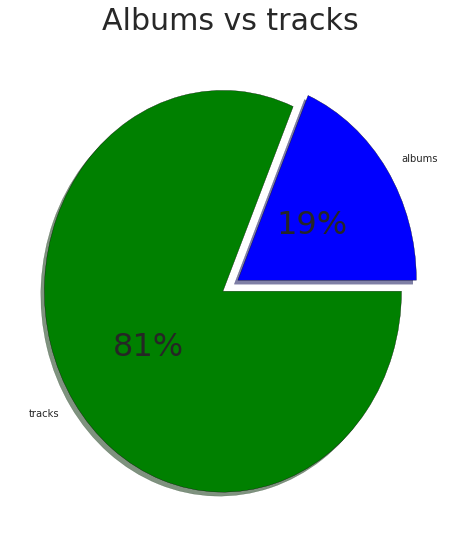

In [15]:
conn = sqlite3.connect("chinook.db")
df_4 = pd.read_sql_query(query, conn)

plt.figure(figsize=(8, 9))


plt.pie(x = df_4["percent"],
        labels = df_4["album_purchase"],
        autopct='%.0f%%',
        explode=[0.05]*2,
        pctdistance=0.5,
        shadow=True,
        textprops={'fontsize': 32})

plt.xticks(fontsize=18)
plt.yticks(fontsize=12)
plt.title("Albums vs tracks", fontsize=30)
plt.show()

(Alternative approach)


**A method without using EXCEPT - Breakdown**

I feel using EXCEPT is a much harder approach, and the same can be achieved with the following:


**first subquery: invoice_albums**
- GROUP BY invoice_id, each track and unique album is counted
- therefore, stores number of tracks **per invoice_id**, and each unique album_id per invoice

**second subquery: counted_albums_tracks**
- GROUP BY album_id, meaning it stores the number of tracks **per album_id** as each track_id is counted

**CASE statement**
separated into two:
1. for each unique album_id (i.e. where unique_album_id = 1) 
2. AND the total tracks on an invoice_id = total tracks on an album_id
3. where the condition matches, it is assigned "album(s)", ELSE "single(s)"

Finally, it's all GROUP BY album_or_singles (the above CASE). 

**Other summary stats**

To calculate the total invoices, the invoice_id just needs to be counted:

``` COUNT(tracks_per_invoice.invoice_id) AS total_invoices ```

To calculate the percentage of invoices that correspond to album or singles, the count per invoice_id needs to be divided by the total row count from invoice.

```ROUND(CAST(COUNT(tracks_per_invoice.invoice_id) AS FLOAT) / (SELECT COUNT(*) FROM invoice) * 100, 2) AS percent```

In [16]:
%%sql

WITH tracks_per_invoice AS 
    (SELECT i.invoice_id,
     COUNT(tr.track_id) AS total_track_per_invoice,
     COUNT(DISTINCT tr.album_id) AS unique_album_count,
     tr.album_id AS album_id
     FROM invoice AS i
     INNER JOIN invoice_line AS il ON il.invoice_id = i.invoice_id
     INNER JOIN track AS tr ON tr.track_id = il.track_id
     GROUP BY i.invoice_id),
    
    tracks_per_album AS
    (SELECT tr.album_id AS album_id,
     COUNT(tr.track_id) AS album_track_total
     FROM track AS tr
     GROUP BY album_id)
    
SELECT 
   CASE
       WHEN tracks_per_invoice.unique_album_count = 1
        AND tracks_per_invoice.total_track_per_invoice = tracks_per_album.album_track_total
        THEN "album(s)"
        ELSE "single(s)"
        END AS album_or_single,
    COUNT(tracks_per_invoice.invoice_id) AS total_invoices,
    ROUND(CAST(COUNT(tracks_per_invoice.invoice_id) AS FLOAT) / (SELECT COUNT(*) FROM invoice) * 100, 2) AS percent
FROM tracks_per_invoice
INNER JOIN tracks_per_album ON tracks_per_album.album_id = tracks_per_invoice.album_id
GROUP BY album_or_single;

Done.


album_or_single,total_invoices,percent
album(s),114,18.57
single(s),500,81.43


### Observations
As most of the customers buy individuals tracks, purchasing the most popular tracks from artists instead of full albums would be a good business strategy.